In [27]:
# from reportlab.lib.pagesizes import letter
# from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
# from reportlab.lib.styles import getSampleStyleSheet
# import matplotlib.pyplot as plt
# from io import BytesIO

# # Création du document avec des marges définies
# doc = SimpleDocTemplate("lorem_ipsum_platypus.pdf", pagesize=letter,
#                         rightMargin=50, leftMargin=50, topMargin=50, bottomMargin=50)

# # Récupération des styles de base
# styles = getSampleStyleSheet()
# story = []

# # --- Ajout du titre ---
# title = Paragraph("Gold Analysis - Week 7", style=styles["Title"])
# story.append(title)
# story.append(Spacer(1, 24))  # Espace après le titre

# # --- Ajout d'un texte Lorem Ipsum ---
# lorem_text = """
# Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. 
# Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. 
# Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. 
# Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
# """
# paragraph = Paragraph(lorem_text, style=styles["Normal"])
# story.append(paragraph)
# story.append(Spacer(1, 12))  # Espace de 12 points

# # --- Génération d'un graphique avec matplotlib ---
# x = range(10)
# y = [xi ** 2 for xi in x]

# plt.figure(figsize=(5, 3))
# plt.plot(x, y, marker='o', linestyle='-', color='blue')
# plt.title("Exemple de graphique")
# plt.xlabel("x")
# plt.ylabel("x²")

# # Sauvegarder le graphique dans un buffer en mémoire
# buffer = BytesIO()
# plt.savefig(buffer, format='png')
# buffer.seek(0)
# print(buffer)
# raise SystemExit
# plt.close()

# # --- Insertion du graphique dans le PDF ---
# img = Image(buffer, width=400, height=300)  # Vous pouvez ajuster la taille selon vos besoins
# story.append(img)
# story.append(Spacer(1, 12))

# # --- Ajout d'un texte complémentaire ---
# more_text = "Ceci est un texte supplémentaire après l'image."
# paragraph2 = Paragraph(more_text, style=styles["Normal"])
# story.append(paragraph2)

# # --- Construction du PDF ---
# doc.build(story)

# print("Le PDF 'lorem_ipsum_platypus.pdf' a été créé avec le titre, du texte et une image incorporée.")


In [141]:
import json
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import kurtosis, skew
import mplfinance as mpf

# Set locale for time-related functions to English (United States)
import locale
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')


'en_US.UTF-8'

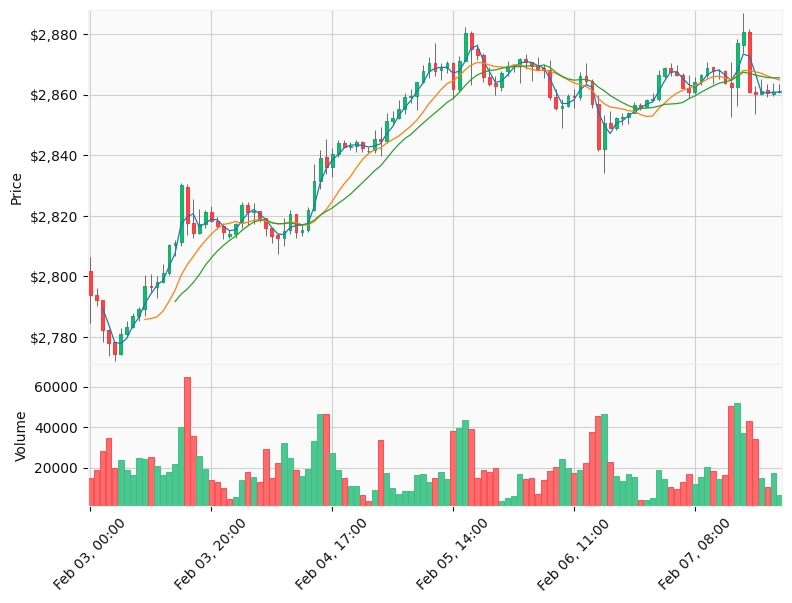

In [142]:


# Remplacez ces valeurs par vos identifiants personnels
access_token = "bddbaa8f7251b0ba039452cb998a3905-aed4d2d69c1d1543dec8e1c3c18b4c65"
accountID = "101-002-30836297-001"

# Initialisation du client API en mode practice (pour live, changez l'environnement si nécessaire)
api = API(access_token=access_token)

# Paramètres pour récupérer les chandelles (candles) journalières de l'instrument XAU_USD
instrument = "XAU_USD"
granularity = "H1"  # D pour Daily

# Paramètres de la requête
params = {
    "from": 1738368000,
    "to": 1739084400,
    "granularity": granularity,
}

# Création de l'endpoint pour récupérer les chandelles
r = instruments.InstrumentsCandles(instrument=instrument, params=params)

# Exécution de la requête via l'API
api.request(r)

# Vérification de la présence de données dans la réponse
if "candles" not in r.response:
    print("Erreur lors de la récupération des données :", r.response)
    exit()

candles = r.response["candles"]
# display(candles)

# Traitement des données : extraction de la date et du prix de clôture pour chaque candle complète
records = []
for candle in candles:
    if candle.get("complete", False):
        time_str    = candle["time"]
        volume = float(candle["volume"])
        open_price = float(candle["mid"]["o"])
        close_price = float(candle["mid"]["c"])
        low_price   = float(candle["mid"]["l"])
        high_price  = float(candle["mid"]["h"])
        records.append({"Date": time_str, 
                        "Open": open_price, 
                        "High": high_price,
                        "Low": low_price, 
                        "Close": close_price, 
                        "Volume": volume,
                        })

# Création d'un DataFrame pandas pour faciliter l'analyse
df = pd.DataFrame(records)
df["Date"] = pd.to_datetime(df["Date"])
# rajouter une heure pour la date
df["Date"] = df["Date"] + timedelta(hours=1)
df.set_index("Date", inplace=True)

# configure mpf to return fig and axes
fig, axes = mpf.plot(df,
         type='candle',
        #  style='yahoo',
         volume=True,
         returnfig=True,
         tight_layout=True,
         mav=(3, 10, 15),
         style='yahoo',)

axes[0].yaxis.set_label_position("left")
axes[0].yaxis.tick_left()

# For the volume panel: set the y-axis label and ticks to the left
# Note: if volume is True and no additional panels are specified,
# mplfinance usually returns two axes: axes[0] for the main panel and axes[1] for volume.
axes[1].yaxis.set_label_position("left")
axes[1].yaxis.tick_left()

axes[2].yaxis.set_label_position("left")
axes[2].yaxis.tick_left()

# Optionally, you can set your own labels:
axes[0].set_ylabel("Price")
axes[1].set_ylabel("Volume")
axes[2].set_ylabel("Volume")

# add $ on price axis
axes[0].yaxis.set_major_formatter('${x:,.0f}')

# Display the figure
# fig.show()
# Save the figure to a file
fig.savefig('candlestick.png')


In [143]:

# Calcul des statistiques sur les prix de clôture
prix_cloture   = df["Close"]
moyenne        = prix_cloture.mean()
variance       = prix_cloture.var()
ecart_type     = prix_cloture.std()
asymetrie      = skew(prix_cloture)
kurtosis_exces = kurtosis(prix_cloture)  # Kurtosis en excès (0 pour une distribution normale)

# Affichage des résultats
print(f"\nStatistiques pour l'or (instrument: {instrument}) de {df.index[0]} à {df.index[-1]} :")
print(f"Moyenne de clôture       : {moyenne:.2f} USD")
print(f"Variance                : {variance:.4f}")
print(f"Écart-type              : {ecart_type:.2f}")
print(f"Asymétrie (Skewness)    : {asymetrie:.2f}")
print(f"Kurtosis (excès)        : {kurtosis_exces:.2f}")


Statistiques pour l'or (instrument: XAU_USD) de 2025-02-03 00:00:00+00:00 à 2025-02-07 22:00:00+00:00 :
Moyenne de clôture       : 2843.01 USD
Variance                : 755.8860
Écart-type              : 27.49
Asymétrie (Skewness)    : -0.80
Kurtosis (excès)        : -0.52


In [144]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
from reportlab.lib import colors

from reportlab.lib.styles import getSampleStyleSheet
import matplotlib.pyplot as plt
from io import BytesIO

styles = getSampleStyleSheet()

def get_h2(text):
    return Paragraph(text, style=styles["h2"])

def get_normal(text):
    return Paragraph(text, style=styles["Normal"])

def get_table(data):
    # data = [
    # ["Date", "Price", "Volume"],
    # ["2025-03-01", "$1850", "5000"],
    # ["2025-03-02", "$1860", "4800"],
    # ["2025-03-03", "$1845", "5200"],
    # ["2025-03-04", "$1870", "5100"],
    # ["2025-03-05", "$1865", "4950"],
    # ]

    # --- Create the Table ---
    table = Table(data)

    # --- Style the Table ---
    table_style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.darkblue),    # Header background
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),     # Header text color
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),                 # Center all cells
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),       # Bold font for header
        ('FONTSIZE', (0, 0), (-1, 0), 12),                     # Font size for header
        ('BOTTOMPADDING', (0, 0), (-1, 0), 8),                 # Padding for header
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),        # Background for data cells
        ('GRID', (0, 0), (-1, -1), 1, colors.black),           # Grid lines
        ('FONTNAME', (0, 0), (0, -1), 'Helvetica-Bold'),       # Bold font for first column
    ])

    table.setStyle(table_style)

    return table

In [145]:
# Création du document avec des marges définies
doc = SimpleDocTemplate("lorem_ipsum_platypus.pdf", pagesize=letter,
                        rightMargin=50, leftMargin=50, topMargin=50, bottomMargin=50)

# Récupération des styles de base
story = []

# --- Ajout du titre ---
title = Paragraph("Gold Analysis - Week 7", style=styles["Title"])
story.append(title)
story.append(Spacer(1, 24))  # Espace après le titre


# --- Introduction des statistiques ---
story.append(get_h2("Period Analysis"))
# start date = jour de la semaine, mois, années ecrit en anglais
story.append(get_normal(f"Start Date : {df.index[0].strftime('%A, %B %d, %Y')}"))
story.append(get_normal(f"End Date   : {df.index[-1].strftime('%A, %B %d, %Y')}"))
story.append(get_normal(f"Number of candles : {len(df)}"))
# story.append(get_normal("News : ..."))

# --- Insertion du graphique dans le PDF ---
story.append(get_h2("Price Charts"))
img = Image('candlestick.png', width=400, height=300)  # Vous pouvez ajuster la taille selon vos besoins
# img = Image(buffer, width=400, height=300)  # Vous pouvez ajuster la taille selon vos besoins
story.append(img)
story.append(Spacer(1, 12))

# --- Weekly statistics ---
data = [
    ["Stat", "Value"],
    ["Mean Close Price", f"{moyenne:.2f} CAD"],
    ["Variance", f"{variance:.4f}"],
    ["Standard Deviation", f"{ecart_type:.2f} CAD"],
    ["Skewness", f"{asymetrie:.2f}"],
    ["Kurtosis", f"{kurtosis_exces:.2f}"],
]
story.append(get_h2("Weekly Statistics"))
story.append(get_table(data))


story.append(PageBreak())

# --- Insertion du graphique dans le PDF ---
story.append(get_h2("Time Series Decomposition"))
img = Image('decomposition.png', width=400, height=300)  # Vous pouvez ajuster la taille selon vos besoins
# img = Image(buffer, width=400, height=300)  # Vous pouvez ajuster la taille selon vos besoins
story.append(img)
story.append(Spacer(1, 12))




# --- Construction du PDF ---
doc.build(story)
print("Le PDF 'lorem_ipsum_platypus.pdf' a été créé avec le titre, du texte et une image incorporée.")


Le PDF 'lorem_ipsum_platypus.pdf' a été créé avec le titre, du texte et une image incorporée.


In [146]:
display(styles.byName)
display(styles.byAlias)

{'Normal': <ParagraphStyle 'Normal'>,
 'BodyText': <ParagraphStyle 'BodyText'>,
 'Italic': <ParagraphStyle 'Italic'>,
 'Heading1': <ParagraphStyle 'Heading1'>,
 'Title': <ParagraphStyle 'Title'>,
 'Heading2': <ParagraphStyle 'Heading2'>,
 'Heading3': <ParagraphStyle 'Heading3'>,
 'Heading4': <ParagraphStyle 'Heading4'>,
 'Heading5': <ParagraphStyle 'Heading5'>,
 'Heading6': <ParagraphStyle 'Heading6'>,
 'Bullet': <ParagraphStyle 'Bullet'>,
 'Definition': <ParagraphStyle 'Definition'>,
 'Code': <ParagraphStyle 'Code'>,
 'UnorderedList': <ListStyle 'UnorderedList'>,
 'OrderedList': <ListStyle 'OrderedList'>}

{'h1': <ParagraphStyle 'Heading1'>,
 'title': <ParagraphStyle 'Title'>,
 'h2': <ParagraphStyle 'Heading2'>,
 'h3': <ParagraphStyle 'Heading3'>,
 'h4': <ParagraphStyle 'Heading4'>,
 'h5': <ParagraphStyle 'Heading5'>,
 'h6': <ParagraphStyle 'Heading6'>,
 'bu': <ParagraphStyle 'Bullet'>,
 'df': <ParagraphStyle 'Definition'>,
 'ul': <ListStyle 'UnorderedList'>,
 'ol': <ListStyle 'OrderedList'>}

In [ ]:
df.index[0]

Timestamp('2025-02-02 23:00:00+0000', tz='UTC')

In [90]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# Generate sample data for 10 business days
dates = pd.date_range(start='2025-02-03', periods=10, freq='B')
# Create a DataFrame with random OHLC data
df = pd.DataFrame(index=dates)

# Generate random Open and Close values between 100 and 110
df['Open'] = np.round(np.random.uniform(100, 110, size=len(dates)), 2)
df['Close'] = np.round(np.random.uniform(100, 110, size=len(dates)), 2)
# Ensure High is at least as high as Open/Close and add a random increment
df['High'] = np.maximum(df['Open'], df['Close']) + np.round(np.random.uniform(0, 5, size=len(dates)), 2)
# Ensure Low is at most as low as Open/Close and subtract a random decrement
df['Low'] = np.minimum(df['Open'], df['Close']) - np.round(np.random.uniform(0, 5, size=len(dates)), 2)
# Generate random Volume values between 1000 and 5000
df['Volume'] = np.random.randint(1000, 5000, size=len(dates))

# Display a preview of the generated data
print(df.head())




              Open   Close    High     Low  Volume
2025-02-03  104.31  108.37  112.13  101.83    2796
2025-02-04  103.22  103.69  106.87  102.66    3557
2025-02-05  102.93  108.16  113.09  101.88    3170
2025-02-06  105.70  105.94  106.83  104.99    1758
2025-02-07  103.49  108.16  110.66  103.45    1224


/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_4403/172187759.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


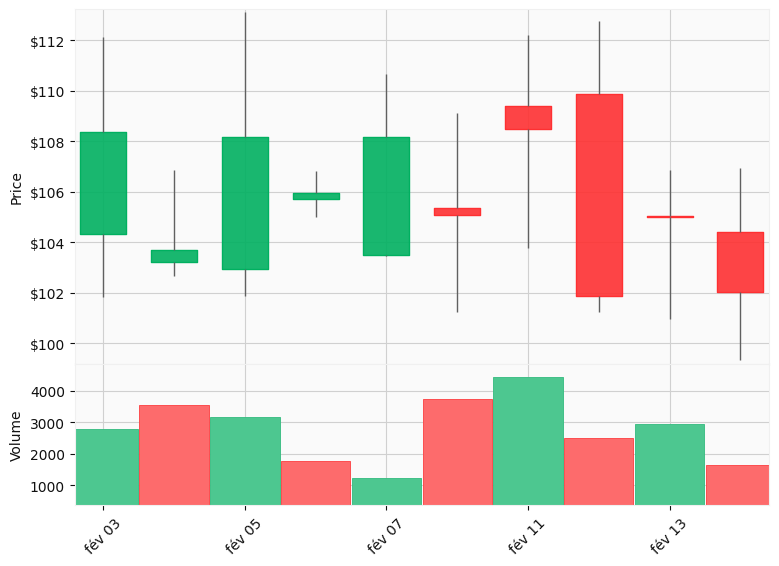

In [ ]:
# Plot the candlestick chart with volume using the "yahoo" style.
# Also display two moving averages: one over 3 periods and one over 6 periods.
fig, axes = mpf.plot(df,
         type='candle',
        #  style='yahoo',
         volume=True,
         returnfig=True,
         tight_layout=True,
         style='yahoo',)

axes[0].yaxis.set_label_position("left")
axes[0].yaxis.tick_left()

# For the volume panel: set the y-axis label and ticks to the left
# Note: if volume is True and no additional panels are specified,
# mplfinance usually returns two axes: axes[0] for the main panel and axes[1] for volume.
axes[1].yaxis.set_label_position("left")
axes[1].yaxis.tick_left()

axes[2].yaxis.set_label_position("left")
axes[2].yaxis.tick_left()

# Optionally, you can set your own labels:
axes[0].set_ylabel("Price")
axes[1].set_ylabel("Volume")
axes[2].set_ylabel("Volume")

# add $ on price axis
axes[0].yaxis.set_major_formatter('${x:,.0f}')

# Display the figure
fig.show()
# Save the figure to a file
fig.savefig('candlestick_chart.png')

In [108]:
axes

[<Axes: ylabel='Price'>,
 <Axes: ylabel='Volume'>,
 <Axes: ylabel='Volume'>,
 <Axes: >]